In [1]:
import msprime as ms
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Model Parameters

In [2]:
# Population sizes
ab_size = 1000
a1_size = 1000
a2_size = 1000
b_size = 1000
a2b_size = 1000

# Time parameters (generations)
time_2_admixture_event = 100
new_map_arises = 2000
ancestral_split_time = 4000

# Admixture proportions
admixture_proportions = [0.5, 0.5]

# Samples
n_samples = 500

# Sequence
sequence_length = 1_000_000  # 1 Mb

## Recombination Maps

In [6]:
def create_simple_recomb_map(length_bp, hotspot_center, hotspot_width=1000, hotspot_rate=1e-5):
    """Create a recombination map with a single hotspot and zero background rate."""
    hotspot_start = max(0, hotspot_center - hotspot_width)
    hotspot_end = min(length_bp, hotspot_center + hotspot_width)
    positions = [0, hotspot_start, hotspot_end, length_bp]
    rates = [0, hotspot_rate, 0]
    return ms.RateMap(position=positions, rate=rates)


def merge_recomb_maps(maps, proportions):
    """Merge recombination maps using weighted average."""
    positions = np.unique(np.concatenate([m.position for m in maps]))
    mids = (positions[:-1] + positions[1:]) / 2
    
    def get_rates(m, pos):
        idx = np.searchsorted(m.position, pos, side='right') - 1
        return m.rate[np.clip(idx, 0, len(m.rate) - 1)]
    
    all_rates = np.array([get_rates(m, mids) for m in maps])
    merged_rates = np.average(all_rates, axis=0, weights=proportions)
    return ms.RateMap(position=positions, rate=merged_rates)


# Create maps with single hotspots at different positions
map_ancestral = create_simple_recomb_map(sequence_length, hotspot_center=300_000)
map_A2 = create_simple_recomb_map(sequence_length, hotspot_center=700_000)
map_B = map_ancestral
map_A2B = merge_recomb_maps([map_A2, map_B], admixture_proportions)



## Population Flag Encoding

We use bits 24-27 of the node `flags` field to encode population IDs.
These bits are unused by tskit (bits 0-15) and msprime (bits 16-19).

In [8]:
# Population flag encoding using bits 24-27 (4 bits = up to 16 populations)
POP_BIT_OFFSET = 24
POP_MASK = 0xF << POP_BIT_OFFSET  # 4 bits

# Population IDs (1-indexed so 0 means "not tagged")
POP_IDS = {
    'A2B': 1,
    'A2': 2,
    'A1': 3,
    'B': 4,
    'AB': 5,
}

# Reverse mapping
POP_NAMES = {v: k for k, v in POP_IDS.items()}


def encode_pop_flag(pop_name):
    """Convert population name to flag bits."""
    return POP_IDS[pop_name] << POP_BIT_OFFSET


def decode_pop_flag(flags):
    """Extract population name from node flags."""
    pop_id = (flags & POP_MASK) >> POP_BIT_OFFSET
    return POP_NAMES.get(pop_id, None)


def is_re_node(flags):
    """Check if a node is a recombination event node."""
    return bool(flags & ms.NODE_IS_RE_EVENT)


## Functions to tag the recombination events with the population they occur in 

In [9]:
def tag_new_re_nodes(ts, pop_name, n_nodes_before=0):
    """
    Tag newly created RE nodes with a population flag. 
    When using initial_state to continue a simulation, new nodes are added
    starting from index n_nodes_before. This function tags only those new
    RE nodes with the specified population
    """
    tables = ts.dump_tables()
    flags = tables.nodes.flags.copy()
    
    pop_flag = encode_pop_flag(pop_name)
    n_tagged = 0
    
    for node_id in range(n_nodes_before, ts.num_nodes):
        if is_re_node(flags[node_id]):
            # Add population flag to existing flags
            flags[node_id] |= pop_flag
            n_tagged += 1
    
    tables.nodes.flags = flags
    return tables.tree_sequence(), n_tagged

def count_tagged_re_nodes(ts):
    """Count RE nodes by population tag."""
    counts = {name: 0 for name in POP_IDS.keys()}
    counts['untagged'] = 0
    
    for node in ts.nodes():
        if is_re_node(node.flags):
            pop = decode_pop_flag(node.flags)
            if pop:
                counts[pop] += 1
            else:
                counts['untagged'] += 1
    
    return counts

## Traverse edges to collect recombination events

In [22]:
def extract_recombinations(ts):
    """
    Extract all recombination events from a tree sequence with tagged RE nodes.
    After operations like union() and simplify(), RE node pairs
    may no longer be consecutive. This function finds pairs by matching
    times, edge structure, AND population tags.
    """
    # Build edge index by parent for fast lookup
    edges_by_parent = {}
    for edge in ts.edges():
        if edge.parent not in edges_by_parent:
            edges_by_parent[edge.parent] = []
        edges_by_parent[edge.parent].append(edge)

    # Collect all RE nodes, grouped by (time, population) to ensure correct pairing
    from collections import defaultdict
    re_nodes_by_time_pop = defaultdict(list)

    for node in ts.nodes():
        if is_re_node(node.flags):
            pop = decode_pop_flag(node.flags)
            # Group by (time, population) - both must match for a valid pair
            re_nodes_by_time_pop[(node.time, pop)].append(node)

    events = []
    processed_nodes = set()

    # For each (time, population) group, find valid pairs
    for (time, population), nodes in re_nodes_by_time_pop.items():
        if len(nodes) < 2:
            continue

        # Try to match nodes into pairs based on edge structure
        for i, node1 in enumerate(nodes):
            if node1.id in processed_nodes:
                continue

            edges1 = edges_by_parent.get(node1.id, [])
            if len(edges1) != 1:
                continue

            child1 = edges1[0].child

            # Look for a matching node with same child
            for node2 in nodes[i+1:]:
                if node2.id in processed_nodes:
                    continue

                edges2 = edges_by_parent.get(node2.id, [])
                if len(edges2) != 1:
                    continue

                child2 = edges2[0].child

                # Found a pair: same time, same population, same child, each with 1 edge
                if child1 == child2:
                    edge_pair = sorted([edges1[0], edges2[0]], key=lambda e: e.left)

                    # Check edges are continuous (no gaps)
                    if edge_pair[0].right == edge_pair[1].left:
                        events.append({
                            'position': edge_pair[0].right,
                            'time': time,
                            'population': population,
                            'child_node': child1,
                            're_node_left': node1.id,
                            're_node_right': node2.id,
                        })

                        processed_nodes.add(node1.id)
                        processed_nodes.add(node2.id)
                        break

    return events

def recombinations_to_dataframe(events):
    """Convert list of recombination events to DataFrame."""
    if not events:
        return pd.DataFrame(columns=['position', 'time', 'population'])
    return pd.DataFrame(events)

## Run simulations

In [23]:
maps = {
    'A2B': map_A2B,
    'A2': map_A2,
    'B': map_B,
    'ancestral': map_ancestral
}

pop_sizes = {
    'AB': ab_size,
    'A1': a1_size,
    'A2': a2_size,
    'B': b_size,
    'A2B': a2b_size
}
seed=42
time_params = (time_2_admixture_event, new_map_arises, ancestral_split_time)

In [24]:
map_A2B = maps['A2B']
map_A2 = maps['A2']
map_B = maps['B']
map_ancestral = maps['ancestral']
t_admix, t_new_map, t_split = time_params

stats = {}


In [25]:
# Start at 0 by default
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2B'])

ts_A2B = ms.sim_ancestry(
    samples={'pop': n_samples},
    demography=dem,
    recombination_rate=map_A2B,
    sequence_length=sequence_length,
    end_time=t_admix,
    record_full_arg=True,
    random_seed=seed
)
ts_A2B, n_tagged = tag_new_re_nodes(ts_A2B, 'A2B', n_nodes_before=0)
stats['A2B'] = n_tagged

In [26]:
# Split into A2 and B branches 
samples = ts_A2B.samples()
n_to_A2 = int(len(samples) * admixture_proportions[0])
np.random.seed(seed + 1)
shuffled = np.random.permutation(samples)
samples_A2 = shuffled[:n_to_A2]
samples_B = shuffled[n_to_A2:]

# Simplify with keep_unary=True to preserve RE nodes
ts_for_A2 = ts_A2B.simplify(samples=samples_A2, keep_unary=True)
ts_for_B = ts_A2B.simplify(samples=samples_B, keep_unary=True)

In [27]:
# A2 population (admixture -> new map arises)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2'])

n_before = ts_for_A2.num_nodes
ts_A2 = ms.sim_ancestry(
    initial_state=ts_for_A2,
    demography=dem,
    recombination_rate=map_A2,
    start_time=t_admix,  # Enforce start time
    end_time=t_new_map,
    record_full_arg=True,
    random_seed=seed + 2
)

ts_A2, n_tagged = tag_new_re_nodes(ts_A2, 'A2', n_nodes_before=n_before)
stats['A2'] = n_tagged

In [28]:
# A1 population (new map arises -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A1'])

n_before = ts_A2.num_nodes
ts_A1 = ms.sim_ancestry(
    initial_state=ts_A2,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_new_map,  # Enforce start time
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 3
)

ts_A1, n_tagged = tag_new_re_nodes(ts_A1, 'A1', n_nodes_before=n_before)
stats['A1'] = n_tagged

In [29]:
# B population (admixture -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['B'])

n_before = ts_for_B.num_nodes
ts_B = ms.sim_ancestry(
    initial_state=ts_for_B,
    demography=dem,
    recombination_rate=map_B,
    start_time=t_admix,  # Enforce start time (branch B started at admixture)
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 4
)

ts_B, n_tagged = tag_new_re_nodes(ts_B, 'B', n_nodes_before=n_before)
stats['B'] = n_tagged

In [30]:
# Combine A1 and B branches
node_mapping = np.full(ts_B.num_nodes, tskit.NULL, dtype=np.int32)
ts_combined = ts_A1.union(ts_B, node_mapping=node_mapping)

# Consolidate to single population
tables = ts_combined.dump_tables()
tables.nodes.population = np.zeros(len(tables.nodes), dtype=np.int32)
tables.populations.clear()
tables.populations.add_row(metadata={'name': 'pop', 'description': 'merged'})
ts_combined = tables.tree_sequence()

In [31]:
# AB population
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['AB'])

n_before = ts_combined.num_nodes
ts_final = ms.sim_ancestry(
    initial_state=ts_combined,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_split,  
    record_full_arg=True,
    random_seed=seed + 5
)

ts_final, n_tagged = tag_new_re_nodes(ts_final, 'AB', n_nodes_before=n_before)
stats['AB'] = n_tagged

## Extract information

In [32]:
# Extract recombination events from the final ARG
events = extract_recombinations(ts_final)
df_recombs = recombinations_to_dataframe(events)

print(f"Total recombination events: {len(df_recombs)}")
print(f"\nBy population:")
print(df_recombs['population'].value_counts())

Total recombination events: 692

By population:
population
A2B    437
B      132
A2      94
A1      21
AB       8
Name: count, dtype: int64


In [35]:
# Downsample to 100 samples
np.random.seed(123)
subset_samples = np.random.choice(ts_final.samples(), 100, replace=False)

# Simplify with keep_unary=True to preserve RE nodes on ancestry path
ts_downsampled = ts_final.simplify(samples=subset_samples, keep_unary=True)
# Extract recombinations from downsampled tree sequence
events = extract_recombinations(ts_downsampled)
df_recombs = recombinations_to_dataframe(events)

## Visualization

In [36]:
# Color scheme
colors = {
'A2': '#e41a1c',   # Red - new map
'A1': '#377eb8',   # Blue - ancestral map
'B': '#4daf4a',    # Green - ancestral map
'AB': '#984ea3',   # Purple - deep ancestral
'A2B': '#ff7f00'   # Orange - mixed
}

# Full population names for legend
pop_labels = {
'A2': 'A2 (new map)',
'A1': 'A1 (ancestral)',
'B': 'B (ancestral)',
'AB': 'AB (ancestral)',
'A2B': 'A2B (mixed)'
}

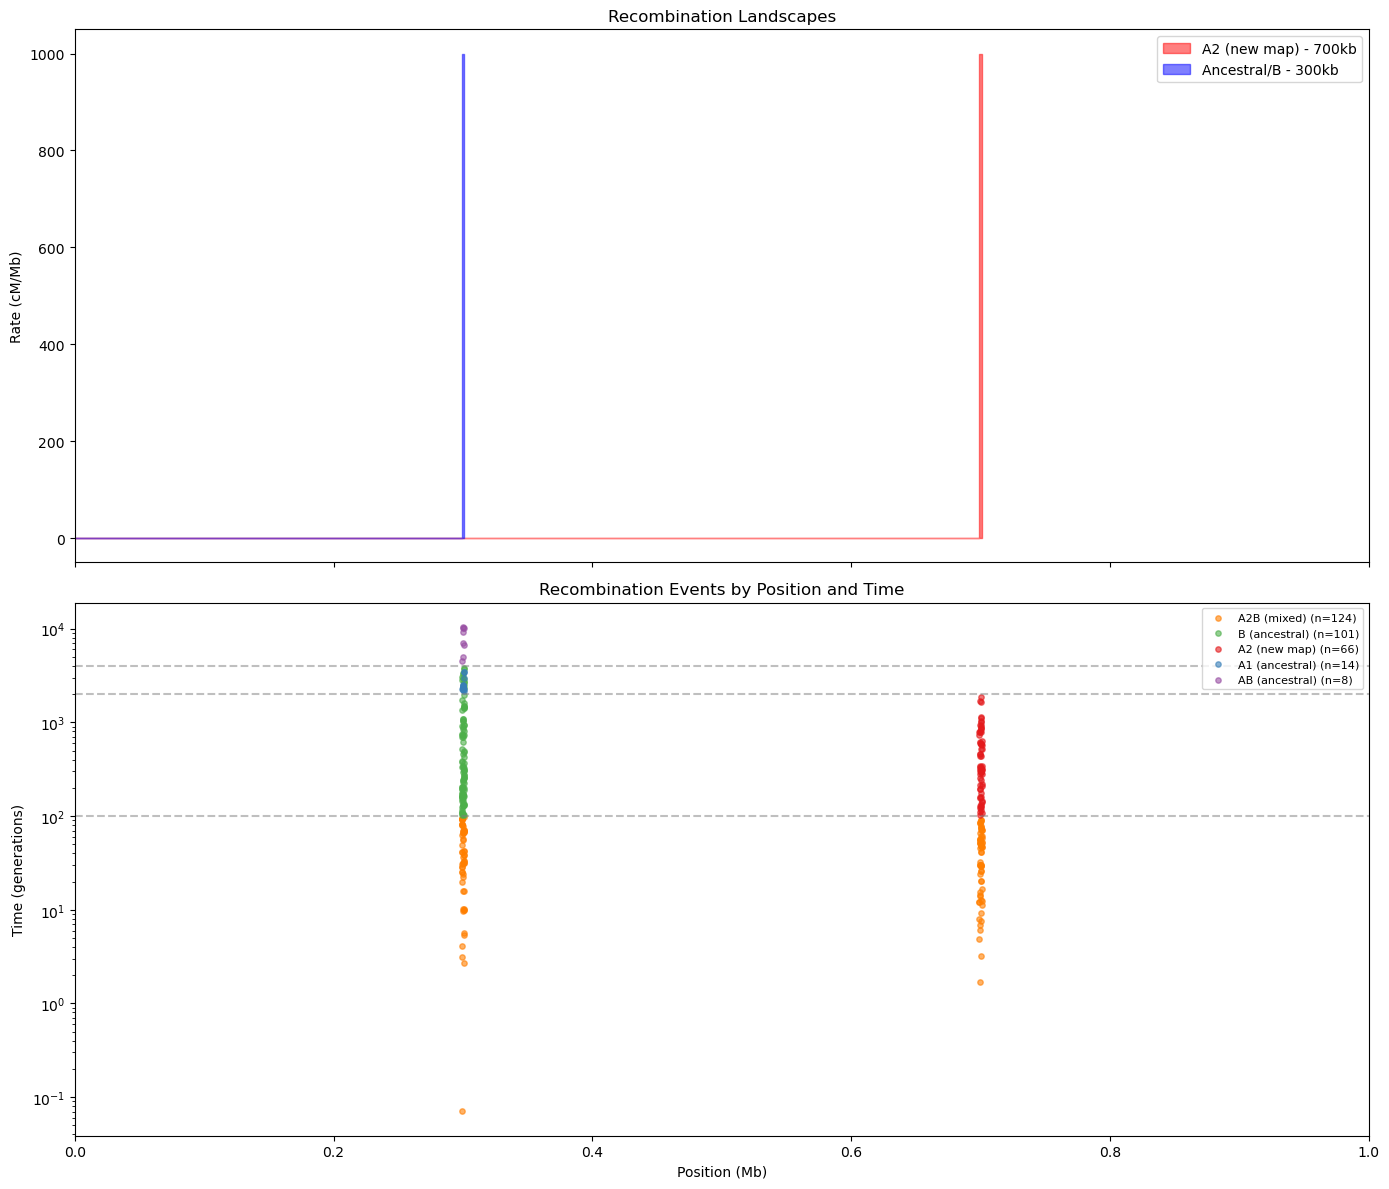

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Panel 1: Recombination maps ---
ax1 = axes[0]
ax1.fill_between(
    map_A2.position[:-1] / 1e6,
    map_A2.rate * 1e8,
    step='post', alpha=0.5, color='red', label='A2 (new map) - 700kb'
)
ax1.fill_between(
    map_ancestral.position[:-1] / 1e6,
    map_ancestral.rate * 1e8,
    step='post', alpha=0.5, color='blue', label='Ancestral/B - 300kb'
)
ax1.set_ylabel('Rate (cM/Mb)')
ax1.set_title('Recombination Landscapes')
ax1.legend(loc='upper right')
ax1.set_xlim(0, sequence_length / 1e6)



# --- Panel 4: Position vs Time scatter ---
ax2 = axes[1]
for pop in df_recombs['population'].dropna().unique():
    events_pop = df_recombs[df_recombs['population'] == pop]
    label = pop_labels.get(pop, pop)
    ax2.scatter(events_pop['position'] / 1e6, events_pop['time'], 
                alpha=0.6, s=15, c=colors.get(pop, 'gray'),
                label=f'{label} (n={len(events_pop)})')

# Time boundary lines
ax2.axhline(y=time_2_admixture_event, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=new_map_arises, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=ancestral_split_time, color='gray', linestyle='--', alpha=0.5)

ax2.set_ylabel('Time (generations)')
ax2.set_xlabel('Position (Mb)')
ax2.set_title('Recombination Events by Position and Time')
ax2.legend(loc='upper right', fontsize=8)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('recombinations_v3_tagged.png', dpi=150, bbox_inches='tight')
plt.show()

## Map simple maps with background recomb rate

In [39]:
def create_simple_recomb_map_background(length_bp, hotspot_center, hotspot_width=1000, hotspot_rate=1e-5, background_rate=1e-8):
    """Create a recombination map with a single hotspot and zero background rate."""
    hotspot_start = max(0, hotspot_center - hotspot_width)
    hotspot_end = min(length_bp, hotspot_center + hotspot_width)
    positions = [0, hotspot_start, hotspot_end, length_bp]
    rates = [background_rate, hotspot_rate, background_rate]
    return ms.RateMap(position=positions, rate=rates)


# Create maps with single hotspots at different positions
map_ancestral = create_simple_recomb_map_background(sequence_length, hotspot_center=300_000)
map_A2 = create_simple_recomb_map_background(sequence_length, hotspot_center=700_000)
map_B = map_ancestral
map_A2B = merge_recomb_maps([map_A2, map_B], admixture_proportions)



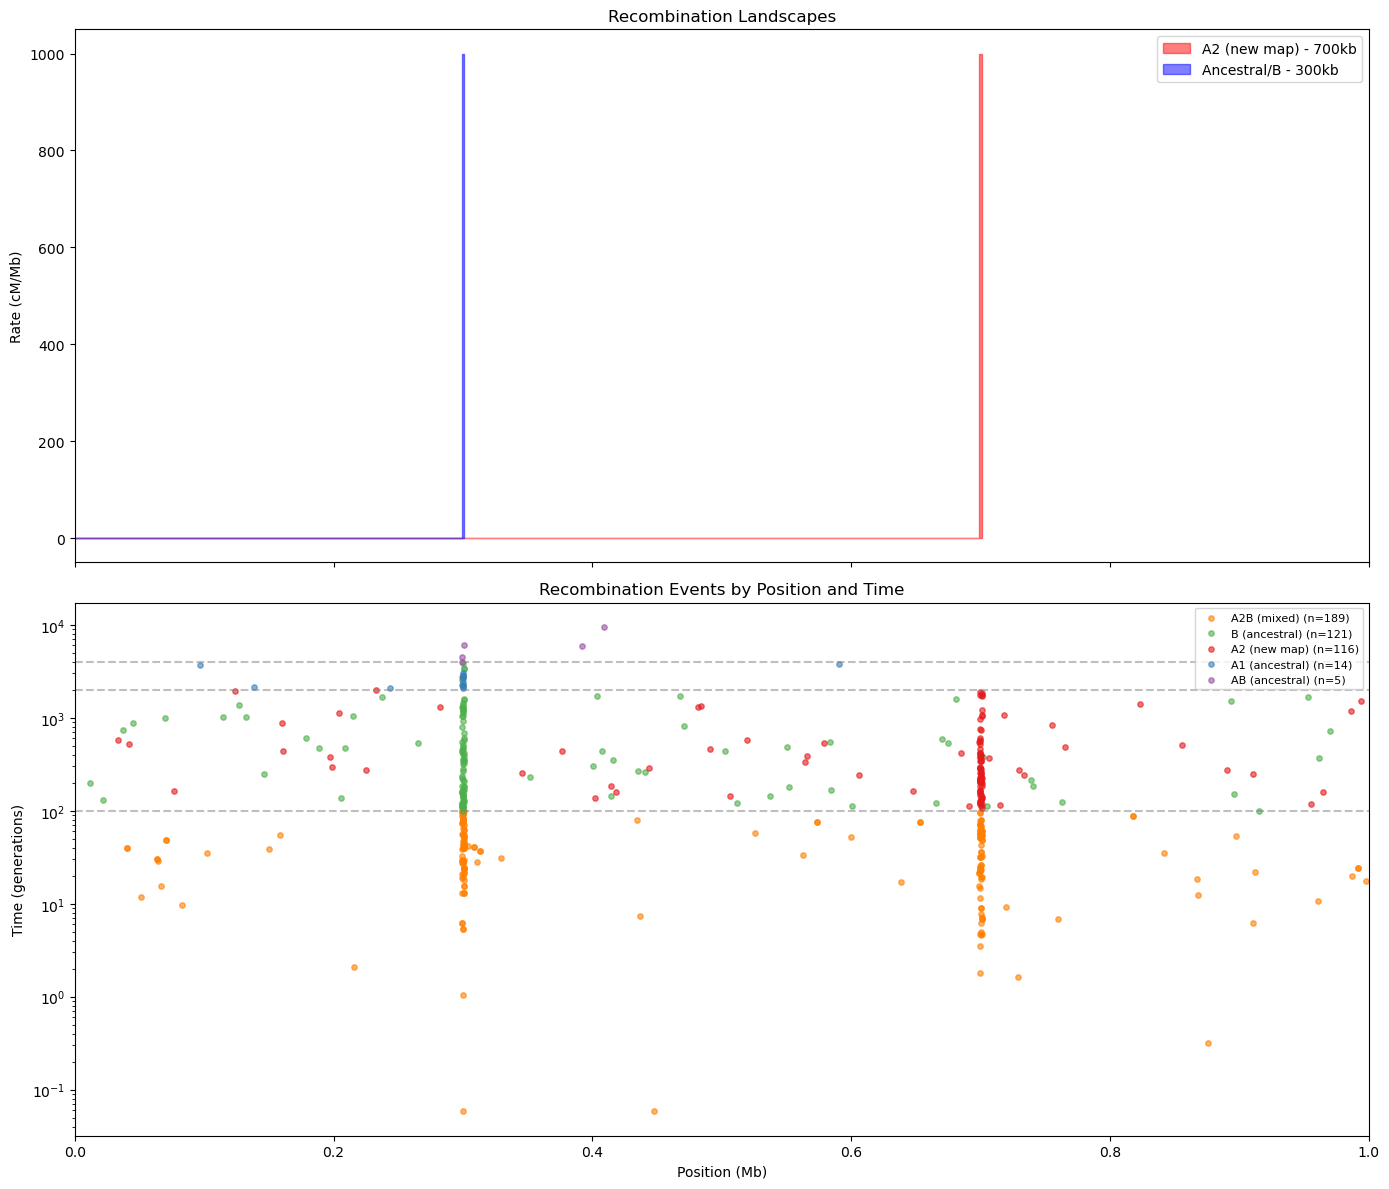

In [40]:
maps = {
    'A2B': map_A2B,
    'A2': map_A2,
    'B': map_B,
    'ancestral': map_ancestral
}

pop_sizes = {
    'AB': ab_size,
    'A1': a1_size,
    'A2': a2_size,
    'B': b_size,
    'A2B': a2b_size
}
seed=42
time_params = (time_2_admixture_event, new_map_arises, ancestral_split_time)
map_A2B = maps['A2B']
map_A2 = maps['A2']
map_B = maps['B']
map_ancestral = maps['ancestral']
t_admix, t_new_map, t_split = time_params

stats = {}

# Start at 0 by default
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2B'])

ts_A2B = ms.sim_ancestry(
    samples={'pop': n_samples},
    demography=dem,
    recombination_rate=map_A2B,
    sequence_length=sequence_length,
    end_time=t_admix,
    record_full_arg=True,
    random_seed=seed
)
ts_A2B, n_tagged = tag_new_re_nodes(ts_A2B, 'A2B', n_nodes_before=0)
stats['A2B'] = n_tagged

# Split into A2 and B branches 
samples = ts_A2B.samples()
n_to_A2 = int(len(samples) * admixture_proportions[0])
np.random.seed(seed + 1)
shuffled = np.random.permutation(samples)
samples_A2 = shuffled[:n_to_A2]
samples_B = shuffled[n_to_A2:]

# Simplify with keep_unary=True to preserve RE nodes
ts_for_A2 = ts_A2B.simplify(samples=samples_A2, keep_unary=True)
ts_for_B = ts_A2B.simplify(samples=samples_B, keep_unary=True)

# A2 population (admixture -> new map arises)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2'])

n_before = ts_for_A2.num_nodes
ts_A2 = ms.sim_ancestry(
    initial_state=ts_for_A2,
    demography=dem,
    recombination_rate=map_A2,
    start_time=t_admix,  # Enforce start time
    end_time=t_new_map,
    record_full_arg=True,
    random_seed=seed + 2
)

ts_A2, n_tagged = tag_new_re_nodes(ts_A2, 'A2', n_nodes_before=n_before)
stats['A2'] = n_tagged

# A1 population (new map arises -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A1'])

n_before = ts_A2.num_nodes
ts_A1 = ms.sim_ancestry(
    initial_state=ts_A2,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_new_map,  # Enforce start time
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 3
)

ts_A1, n_tagged = tag_new_re_nodes(ts_A1, 'A1', n_nodes_before=n_before)
stats['A1'] = n_tagged

# B population (admixture -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['B'])

n_before = ts_for_B.num_nodes
ts_B = ms.sim_ancestry(
    initial_state=ts_for_B,
    demography=dem,
    recombination_rate=map_B,
    start_time=t_admix,  # Enforce start time (branch B started at admixture)
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 4
)

ts_B, n_tagged = tag_new_re_nodes(ts_B, 'B', n_nodes_before=n_before)
stats['B'] = n_tagged

# Combine A1 and B branches
node_mapping = np.full(ts_B.num_nodes, tskit.NULL, dtype=np.int32)
ts_combined = ts_A1.union(ts_B, node_mapping=node_mapping)

# Consolidate to single population
tables = ts_combined.dump_tables()
tables.nodes.population = np.zeros(len(tables.nodes), dtype=np.int32)
tables.populations.clear()
tables.populations.add_row(metadata={'name': 'pop', 'description': 'merged'})
ts_combined = tables.tree_sequence()

# AB population
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['AB'])

n_before = ts_combined.num_nodes
ts_final = ms.sim_ancestry(
    initial_state=ts_combined,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_split,  
    record_full_arg=True,
    random_seed=seed + 5
)

ts_final, n_tagged = tag_new_re_nodes(ts_final, 'AB', n_nodes_before=n_before)
stats['AB'] = n_tagged


# Downsample to 100 samples
np.random.seed(123)
subset_samples = np.random.choice(ts_final.samples(), 100, replace=False)

# Simplify with keep_unary=True to preserve RE nodes on ancestry path
ts_downsampled = ts_final.simplify(samples=subset_samples, keep_unary=True)
# Extract recombinations from downsampled tree sequence
events = extract_recombinations(ts_downsampled)
df_recombs = recombinations_to_dataframe(events)

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Panel 1: Recombination maps ---
ax1 = axes[0]
ax1.fill_between(
    map_A2.position[:-1] / 1e6,
    map_A2.rate * 1e8,
    step='post', alpha=0.5, color='red', label='A2 (new map) - 700kb'
)
ax1.fill_between(
    map_ancestral.position[:-1] / 1e6,
    map_ancestral.rate * 1e8,
    step='post', alpha=0.5, color='blue', label='Ancestral/B - 300kb'
)
ax1.set_ylabel('Rate (cM/Mb)')
ax1.set_title('Recombination Landscapes')
ax1.legend(loc='upper right')
ax1.set_xlim(0, sequence_length / 1e6)



# --- Panel 4: Position vs Time scatter ---
ax2 = axes[1]
for pop in df_recombs['population'].dropna().unique():
    events_pop = df_recombs[df_recombs['population'] == pop]
    label = pop_labels.get(pop, pop)
    ax2.scatter(events_pop['position'] / 1e6, events_pop['time'], 
                alpha=0.6, s=15, c=colors.get(pop, 'gray'),
                label=f'{label} (n={len(events_pop)})')

# Time boundary lines
ax2.axhline(y=time_2_admixture_event, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=new_map_arises, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=ancestral_split_time, color='gray', linestyle='--', alpha=0.5)

ax2.set_ylabel('Time (generations)')
ax2.set_xlabel('Position (Mb)')
ax2.set_title('Recombination Events by Position and Time')
ax2.legend(loc='upper right', fontsize=8)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('recombinations_v3_tagged.png', dpi=150, bbox_inches='tight')
plt.show()

## Hard map

In [46]:
def create_recomb_map(length_bp, hotspot_fold=50, n_hotspots=None, hotspot_width=1000, seed=None):
    """Create a recombination map with hotspots that averages ~1 cM/Mb."""
    if seed is not None:
        np.random.seed(seed)
    if n_hotspots is None:
        n_hotspots = length_bp // 100_000  # ~1 hotspot per 100kb
    
    target_rate_avg = 1e-8
    target_morgans = length_bp * target_rate_avg
    hotspot_total_bp = n_hotspots * hotspot_width * 2
    background_bp = length_bp - hotspot_total_bp
    background_rate = target_morgans / (background_bp + hotspot_total_bp * hotspot_fold)
    hotspot_rate = background_rate * hotspot_fold
    
    hotspot_centers = np.sort(np.random.randint(hotspot_width, length_bp - hotspot_width, n_hotspots))
    
    positions = [0]
    rates = []
    
    for center in hotspot_centers:
        if center - hotspot_width > positions[-1]:
            positions.append(center - hotspot_width)
            rates.append(background_rate)
        positions.append(center + hotspot_width)
        rates.append(hotspot_rate)
    
    positions.append(length_bp)
    rates.append(background_rate)
    
    return ms.RateMap(position=positions, rate=rates)



# Create maps with single hotspots at different positions
map_ancestral = create_recomb_map(sequence_length, hotspot_fold=100, n_hotspots=5, hotspot_width=1000)
map_A2 = create_recomb_map(sequence_length, hotspot_fold=100, n_hotspots=5, hotspot_width=1000)
map_B = map_ancestral
map_A2B = merge_recomb_maps([map_A2, map_B], admixture_proportions)

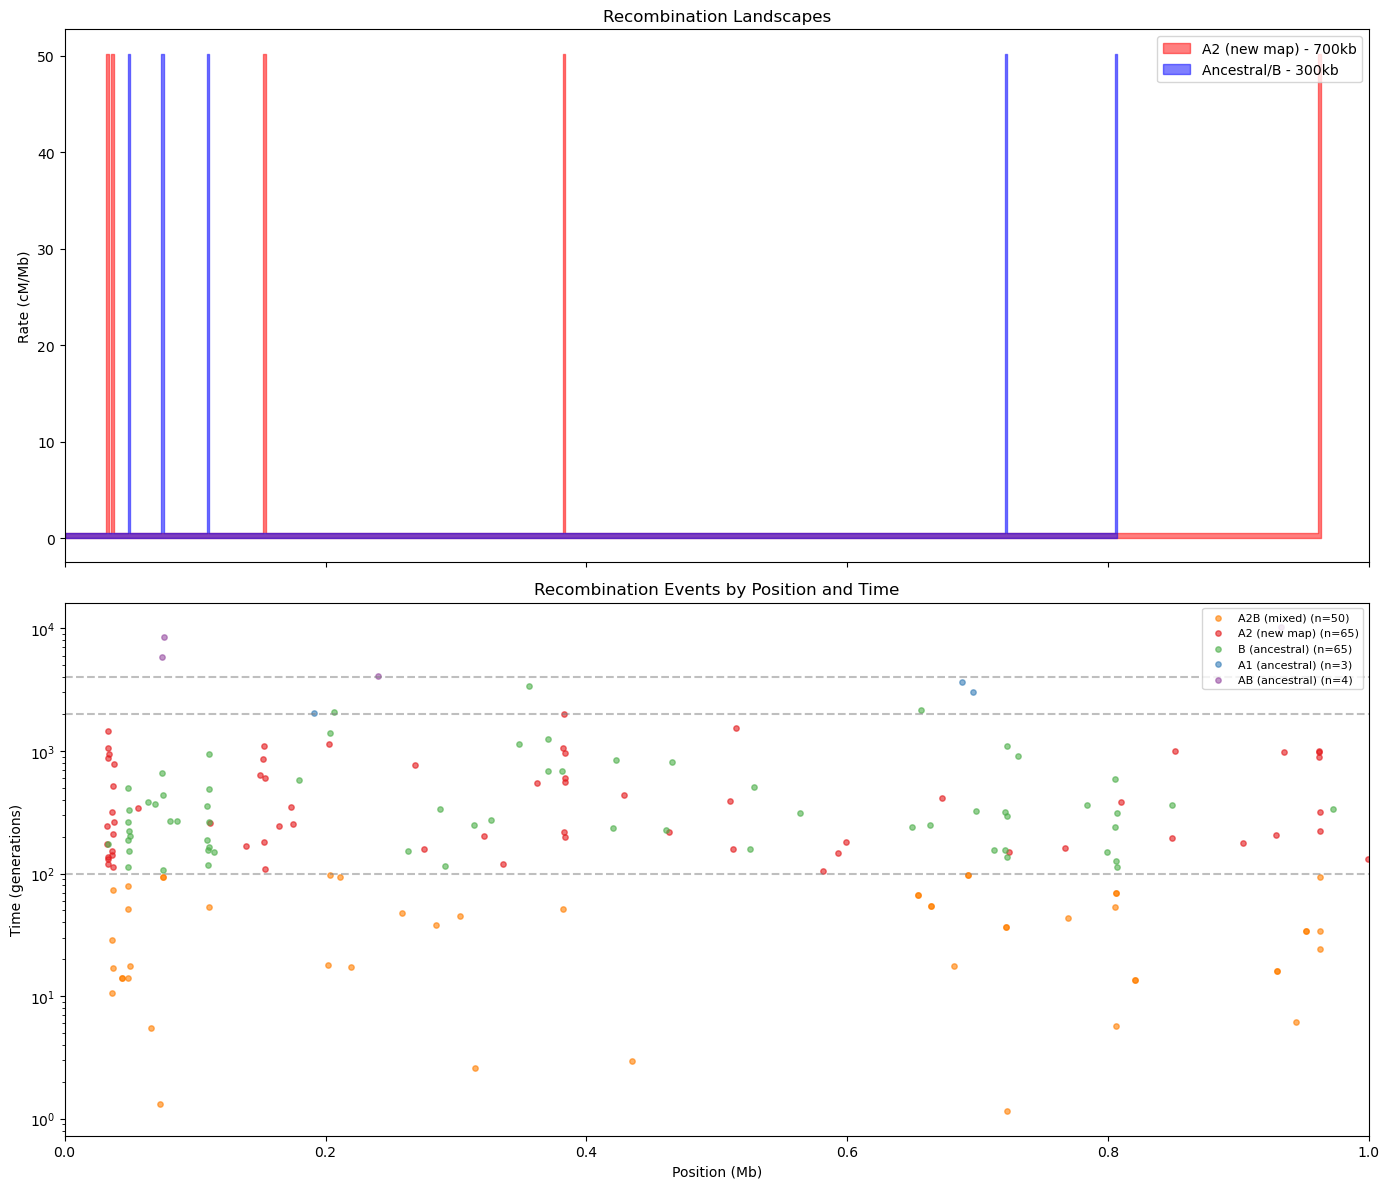

In [47]:
maps = {
    'A2B': map_A2B,
    'A2': map_A2,
    'B': map_B,
    'ancestral': map_ancestral
}

pop_sizes = {
    'AB': ab_size,
    'A1': a1_size,
    'A2': a2_size,
    'B': b_size,
    'A2B': a2b_size
}
seed=42
time_params = (time_2_admixture_event, new_map_arises, ancestral_split_time)
map_A2B = maps['A2B']
map_A2 = maps['A2']
map_B = maps['B']
map_ancestral = maps['ancestral']
t_admix, t_new_map, t_split = time_params

stats = {}

# Start at 0 by default
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2B'])

ts_A2B = ms.sim_ancestry(
    samples={'pop': n_samples},
    demography=dem,
    recombination_rate=map_A2B,
    sequence_length=sequence_length,
    end_time=t_admix,
    record_full_arg=True,
    random_seed=seed
)
ts_A2B, n_tagged = tag_new_re_nodes(ts_A2B, 'A2B', n_nodes_before=0)
stats['A2B'] = n_tagged

# Split into A2 and B branches 
samples = ts_A2B.samples()
n_to_A2 = int(len(samples) * admixture_proportions[0])
np.random.seed(seed + 1)
shuffled = np.random.permutation(samples)
samples_A2 = shuffled[:n_to_A2]
samples_B = shuffled[n_to_A2:]

# Simplify with keep_unary=True to preserve RE nodes
ts_for_A2 = ts_A2B.simplify(samples=samples_A2, keep_unary=True)
ts_for_B = ts_A2B.simplify(samples=samples_B, keep_unary=True)

# A2 population (admixture -> new map arises)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A2'])

n_before = ts_for_A2.num_nodes
ts_A2 = ms.sim_ancestry(
    initial_state=ts_for_A2,
    demography=dem,
    recombination_rate=map_A2,
    start_time=t_admix,  # Enforce start time
    end_time=t_new_map,
    record_full_arg=True,
    random_seed=seed + 2
)

ts_A2, n_tagged = tag_new_re_nodes(ts_A2, 'A2', n_nodes_before=n_before)
stats['A2'] = n_tagged

# A1 population (new map arises -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['A1'])

n_before = ts_A2.num_nodes
ts_A1 = ms.sim_ancestry(
    initial_state=ts_A2,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_new_map,  # Enforce start time
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 3
)

ts_A1, n_tagged = tag_new_re_nodes(ts_A1, 'A1', n_nodes_before=n_before)
stats['A1'] = n_tagged

# B population (admixture -> split)
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['B'])

n_before = ts_for_B.num_nodes
ts_B = ms.sim_ancestry(
    initial_state=ts_for_B,
    demography=dem,
    recombination_rate=map_B,
    start_time=t_admix,  # Enforce start time (branch B started at admixture)
    end_time=t_split,
    record_full_arg=True,
    random_seed=seed + 4
)

ts_B, n_tagged = tag_new_re_nodes(ts_B, 'B', n_nodes_before=n_before)
stats['B'] = n_tagged

# Combine A1 and B branches
node_mapping = np.full(ts_B.num_nodes, tskit.NULL, dtype=np.int32)
ts_combined = ts_A1.union(ts_B, node_mapping=node_mapping)

# Consolidate to single population
tables = ts_combined.dump_tables()
tables.nodes.population = np.zeros(len(tables.nodes), dtype=np.int32)
tables.populations.clear()
tables.populations.add_row(metadata={'name': 'pop', 'description': 'merged'})
ts_combined = tables.tree_sequence()

# AB population
dem = ms.Demography()
dem.add_population(name='pop', initial_size=pop_sizes['AB'])

n_before = ts_combined.num_nodes
ts_final = ms.sim_ancestry(
    initial_state=ts_combined,
    demography=dem,
    recombination_rate=map_ancestral,
    start_time=t_split,  
    record_full_arg=True,
    random_seed=seed + 5
)

ts_final, n_tagged = tag_new_re_nodes(ts_final, 'AB', n_nodes_before=n_before)
stats['AB'] = n_tagged


# Downsample to 100 samples
np.random.seed(123)
subset_samples = np.random.choice(ts_final.samples(), 100, replace=False)

# Simplify with keep_unary=True to preserve RE nodes on ancestry path
ts_downsampled = ts_final.simplify(samples=subset_samples, keep_unary=True)
# Extract recombinations from downsampled tree sequence
events = extract_recombinations(ts_downsampled)
df_recombs = recombinations_to_dataframe(events)

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Panel 1: Recombination maps ---
ax1 = axes[0]
ax1.fill_between(
    map_A2.position[:-1] / 1e6,
    map_A2.rate * 1e8,
    step='post', alpha=0.5, color='red', label='A2 (new map) - 700kb'
)
ax1.fill_between(
    map_ancestral.position[:-1] / 1e6,
    map_ancestral.rate * 1e8,
    step='post', alpha=0.5, color='blue', label='Ancestral/B - 300kb'
)
ax1.set_ylabel('Rate (cM/Mb)')
ax1.set_title('Recombination Landscapes')
ax1.legend(loc='upper right')
ax1.set_xlim(0, sequence_length / 1e6)



# --- Panel 4: Position vs Time scatter ---
ax2 = axes[1]
for pop in df_recombs['population'].dropna().unique():
    events_pop = df_recombs[df_recombs['population'] == pop]
    label = pop_labels.get(pop, pop)
    ax2.scatter(events_pop['position'] / 1e6, events_pop['time'], 
                alpha=0.6, s=15, c=colors.get(pop, 'gray'),
                label=f'{label} (n={len(events_pop)})')

# Time boundary lines
ax2.axhline(y=time_2_admixture_event, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=new_map_arises, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=ancestral_split_time, color='gray', linestyle='--', alpha=0.5)

ax2.set_ylabel('Time (generations)')
ax2.set_xlabel('Position (Mb)')
ax2.set_title('Recombination Events by Position and Time')
ax2.legend(loc='upper right', fontsize=8)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('recombinations_v3_tagged.png', dpi=150, bbox_inches='tight')
plt.show()